In [1]:
from fastai.collab import * 
from sklearn import decomposition
import matplotlib.pyplot as plt

### get and transform datasets to one

In [3]:
answers_df=pd.read_csv('matmat/answers.csv')
items_df=pd.read_csv('matmat/items.csv')
answers_df.shape,answers_df[answers_df.random==0].shape,items_df.shape

((390367, 10), (390351, 10), (1847, 9))

In [68]:
answers_df=answers_df.sort_values(['student','time'],ascending=['True','True'])
answers_df['new_id']=range(0,len(answers_df))
answers_df=answers_df.merge(items_df,how='left',left_on='item',right_on='id')

In [69]:
answers_df['total_error_rate']=answers_df.groupby('student').correct.mean()
#answers_df['trailing_error_rate']=answers_df.groupby('student').apply(lambda x:pd.expanding_mean(x))

In [70]:
answers_df.groupby('student').new_id.count().mean(),answers_df.groupby('student').new_id.count().median()

(20.712421074972145, 10.0)

In [71]:
answers_df.groupby('student')

In [72]:
val_idx=answers_df.groupby('student').tail(4).new_id.values
len(val_idx)/len(answers_df)

0.16571072862204028

In [73]:
data = answers_df
data.head()

,id_x,time,item,student,response_time,correct,answer_x,answer_expected,log,random,...,id,question_y,answer,visualization_y,skill_y,skill_lvl_1_y,skill_lvl_2_y,skill_lvl_3_y,data_y,total_error_rate
0,105330,2015-10-01 16:20:52,1759,1,1861,1,3,3,"{""client_meta"": [[1644, ""3""], [1861, ""finished...",0,...,1759,12/4,3,division_visualization_baskets,2259,2234,2235.0,2259.0,"{'operation':'/','answer':3,'operands':[12,4]}",NaN
1,105331,2015-10-01 16:21:01,1771,1,7006,1,4,4,"{""client_meta"": [[6008, ""soft-keyboard:4""], [6...",0,...,1771,12/3,4,division_visualization_baskets,2268,2234,2235.0,2268.0,"{'operation':'/','answer':4,'operands':[12,3]}",0.857143
2,105332,2015-10-01 16:21:09,1743,1,5288,1,2,2,"{""client_meta"": [[1545, ""6""], [4610, """"], [515...",0,...,1743,6/3,2,division_visualization_baskets,2248,2234,2235.0,2248.0,"{'operation':'/','answer':2,'operands':[6,3]}",0.569832
3,105333,2015-10-01 16:21:12,1787,1,1106,1,5,5,"{""client_meta"": [[945, ""5""], [1106, ""finished""...",0,...,1787,20/4,5,division_visualization_baskets,2279,2234,2235.0,2279.0,"{'operation':'/','answer':5,'operands':[20,4]}",0.322581
4,105334,2015-10-01 16:21:15,1801,1,1403,1,6,6,"{""client_meta"": [[1245, ""6""], [1403, ""finished...",0,...,1801,24/4,6,division_visualization_baskets,2289,2234,2235.0,2289.0,"{'operation':'/','answer':6,'operands':[24,4]}",0.548387


In [157]:
(data.response_time > 40000).sum()

18688

### pufifying data

In [121]:
data.head()

,id_x,time,item,student,response_time,correct,answer_x,answer_expected,log,random,...,id_y,question,answer_y,visualization,skill,skill_lvl_1,skill_lvl_2,skill_lvl_3,data,total_error_rate
0,105330,2015-10-01 16:20:52,1759,1,1861,1,3,3,"{""client_meta"": [[1644, ""3""], [1861, ""finished...",0,...,1759,12/4,3,division_visualization_baskets,2259,2234,2235.0,2259.0,"{'operation':'/','answer':3,'operands':[12,4]}",NaN
1,105331,2015-10-01 16:21:01,1771,1,7006,1,4,4,"{""client_meta"": [[6008, ""soft-keyboard:4""], [6...",0,...,1771,12/3,4,division_visualization_baskets,2268,2234,2235.0,2268.0,"{'operation':'/','answer':4,'operands':[12,3]}",0.857143
2,105332,2015-10-01 16:21:09,1743,1,5288,1,2,2,"{""client_meta"": [[1545, ""6""], [4610, """"], [515...",0,...,1743,6/3,2,division_visualization_baskets,2248,2234,2235.0,2248.0,"{'operation':'/','answer':2,'operands':[6,3]}",0.569832
3,105333,2015-10-01 16:21:12,1787,1,1106,1,5,5,"{""client_meta"": [[945, ""5""], [1106, ""finished""...",0,...,1787,20/4,5,division_visualization_baskets,2279,2234,2235.0,2279.0,"{'operation':'/','answer':5,'operands':[20,4]}",0.322581
4,105334,2015-10-01 16:21:15,1801,1,1403,1,6,6,"{""client_meta"": [[1245, ""6""], [1403, ""finished...",0,...,1801,24/4,6,division_visualization_baskets,2289,2234,2235.0,2289.0,"{'operation':'/','answer':6,'operands':[24,4]}",0.548387


In [124]:
data.drop(np.where(data.response_time > 10000)[0], axis=0, inplace=True)
# numbers = data.groupby('student').count() 
# inds = numbers.iloc[np.where(numbers.id_x < 7)[0]]
# for ind in inds:
#     data.drop(ind, axis=0, inplace=True)

In [137]:
df = pd.DataFrame()
numbers = data.groupby('student').count()
numbers[numbers.id_x > 8]

students = numbers[100:500].id_x.index
data.iloc[np.array(students)]
# for stud in students:
# #     print(data.loc[stud])
#     df.append(pd.Series(data.loc(stud)))

In [127]:
# students = students[100:]
# students

array([ 603,  606,  609,  610, ..., 1299, 1300, 1303, 1304])

In [172]:
d1 = pd.DataFrame(students)
d2 = pd.DataFrame.join(d1, data, how='left', on='student', lsuffix='_jn')
d2.shape

(400, 22)

In [173]:
d2.dropna().shape

(350, 22)

In [146]:
?plt.hist

In [12]:
data['student_efficiency'] = 0
efficiency = data.groupby('student').mean()['correct']
easyness = data.groupby('question').mean()['correct']
difficulty = easyness.apply(lambda x: 1-x)

(array([  437., 45207., 86695., 61632., 29526., 14775.,  4119.,  1878.,  1450.,   215.]),
 array([0.      , 0.044444, 0.088889, 0.133333, 0.177778, 0.222222, 0.266667, 0.311111, 0.355556, 0.4     , 0.444444]),
 <a list of 10 Patch objects>)

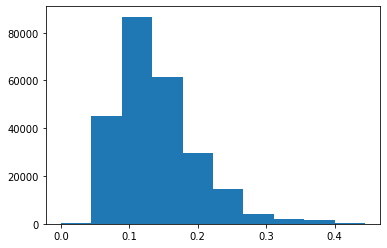

In [13]:
data['difficulty'] = data['question'].apply(lambda x: difficulty[x])
plt.hist(data.difficulty)

In [14]:
def IRT_prob(difficulty, efficiency):
    return 1 / (1 + np.exp(difficulty - efficiency))

In [15]:
data['student_efficiency'] = data['student'].apply(lambda x: efficiency[x])

data['prob'] = IRT_prob(data.difficulty, data.student_efficiency)

### Accuracy with IRT

In [17]:
prob_thresh = np.median(data.prob)
prob_thresh = 0.60
prob_thresh

0.6

In [18]:
print("accuracy with IRT = ", (data.prob * data.correct >= prob_thresh).mean())

accuracy with IRT =  0.8389120658388023


### Cherry picking ^_^

In [19]:
diff_thresh = np.median(data.difficulty)

In [95]:
mask = np.where(data.difficulty < diff_thresh)[0]
cherry_data = data.drop(mask, axis=0)
cherry_data.shape[0] / data.shape[0]

In [ ]:
print("cherry accuracy with IRT = ", (cherry_data.prob * cherry_data.correct >= prob_thresh).mean())

In [ ]:
(cherry_data.correct == 1).mean()

In [ ]:
(data.correct == 1).mean()

### Smart cherry picking ^^__^^

In [ ]:
mask = np.where(data.student_efficiency > 0.75)[0]
smart_cherry_data = data.drop(mask, axis=0)
smart_cherry_data.shape[0] / data.shape[0]

In [ ]:
print("smart cherry accuracy with IRT = ", (smart_cherry_data.prob * smart_cherry_data.correct >= prob_thresh).mean())

In [ ]:
(smart_cherry_data.correct == 1).mean()

In [ ]:
plt.hist(smart_cherry_data.student_efficiency)

In [ ]:
data['question'] = data['question_y']

In [21]:
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from elo import Rate_System
from sympy.utilities.iterables import multiset_permutations
import elo

In [22]:
difficulty = data.groupby('item').correct.mean()

In [23]:
data['difficulty'] = data['item'].apply(lambda x: difficulty[x])

In [24]:
elo = Rate_System()

In [174]:
user_elos, test_elos = [], []
for index, row in data.iterrows():
    user = row['student']
    test = row['item']
    is_solved = row['correct']
    if user not in elo.user_rating:
        elo.add_player(user)
    if test not in elo.test_rating:
        elo.add_test(test)
    elo.elo(user, test, is_solved)
    user_elos.append(elo.user_rating[user])
    test_elos.append(elo.test_rating[test])

In [26]:
data['student_elo'] = user_elos
data['item_elo'] = test_elos

In [27]:
def calc_prob(r_a, r_b):
    return 1 / (1 + 10 ** ((r_b - r_a) / 400))

In [28]:
prob = []
for (r_a, r_b) in zip(data.student_elo, data.item_elo):
    prob.append(calc_prob(r_a, r_b))
data['prob'] = prob

### prediction for incomplete data

In [29]:
def IRT_prob(difficulty, efficiency):
    return 1 / (1 + np.exp(difficulty - efficiency))

def predict_probs(data, student_efficiency, num_questions, method = "IRT"):
    if method == "IRT":
        
        dfty = data.difficulty
        probs = IRT_prob(dfty, student_efficiency)
#         plt.hist(probs)
    #     indexes = np.argpartition(probs - 0.65, -num_questions)[-num_questions:]
        indexes = np.argsort(np.abs(probs - 0.65))[:num_questions]
        questions = data.question[indexes]
        return probs
    else if method == 'Elo':
        user_elos, test_elos = [], []
        for index, row in data.iterrows():
            user = row['student']
            test = row['item']
            is_solved = row['correct']
            if user not in elo.user_rating:
                elo.add_player(user)
            if test not in elo.test_rating:
                elo.add_test(test)
            elo.elo(user, test, is_solved)
            user_elos.append(elo.user_rating[user])
            test_elos.append(elo.test_rating[test])
        
        data['student_elo'] = user_elos
        data['item_elo'] = test_elos
        
        prob = []
        for (r_a, r_b) in zip(data.student_elo, data.item_elo):
            prob.append(calc_prob(r_a, r_b))
#         data['prob'] = prob
        
        return prob

In [30]:
probs = predict_probs(data, 0.5, 5, method = 'Elo')
probs

[0.9999984902776338,
 0.9999803316461985,
 0.9991927774295203,
 0.999934467811851,
 0.9999599100804419,
 0.9999648491495238,
 0.999999968981183,
 0.9854263839453647,
 0.9994381794904287,
 0.9992930575951977,
 0.9998180567257715,
 0.9990901374383844,
 0.9998070801150343,
 0.9998644208629001,
 0.9881862972743086,
 0.9880219327430403,
 1.0,
 0.9999784303782872,
 0.9999997049244771,
 0.9999999489519785,
 0.9999747861024567,
 0.9999975170303054,
 0.9218283881625466,
 0.953000521510822,
 0.9841410090346966,
 0.9999999999999998,
 0.7502677508354685,
 0.9271824055662331,
 0.9843994935491608,
 0.9734082614657679,
 0.997228486726664,
 0.9881248667515299,
 0.9820685855198964,
 0.9324510831039328,
 0.9471555388020849,
 0.9283648297725668,
 0.9999990585268455,
 0.9999992114157829,
 0.9999998318163171,
 0.99999998088477,
 0.999999963440136,
 0.9999999999777447,
 0.7091204494980059,
 0.9832351684523677,
 1.0,
 0.9999999999472786,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9425403623197645,
 0

In [31]:
data['probs'] = probs

In [32]:
num_questions = 5

indexes = np.argsort(np.abs(data.probs - 0.65))[:num_questions]
questions = data.question[indexes]
questions

/home/ayd98/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


69972       6
42052     7+3
241645    NaN
86668     NaN
33244     NaN
Name: question, dtype: object

In [33]:
predict_probs(data, 0.5, 5, method = 'IRT')

0         0.394685
1         0.395194
2         0.419597
3         0.390682
4         0.415961
            ...   
390359    0.410371
390360    0.409674
390361    0.423498
390362    0.398772
390366    0.411651
Name: difficulty, Length: 245934, dtype: float64

In [34]:
num_questions = 5

indexes = np.argsort(np.abs(data.probs - 0.65))[:num_questions]
questions = data.question[indexes]
questions

69972       6
42052     7+3
241645    NaN
86668     NaN
33244     NaN
Name: question, dtype: object

### ilo plots

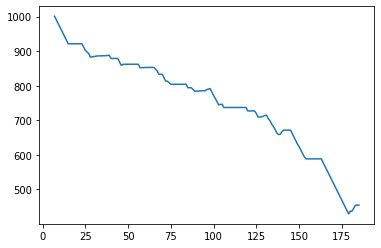

In [35]:
stud1 = data[data.student == 2]
plt.plot(stud1.student_elo)

In [94]:
# stud1 = data[data.student == 4931]
# plt.plot(stud1.student_elo)

###  adding results to tables and jsons

In [23]:
data.to_csv('to_den.csv')

In [63]:
df = pd.read_csv('new_recommended_tasks.csv')
df.head()
# questions = []

# for index, row in df.iterrows():
#     temp = []
#     task1 = 
#     for task_id in row.recommended_tasks:
#         q = data[data.item == task_id].question
#         temp.append(q)
        
#     questions.append(temp)
    

,Unnamed: 0,student,recommended_tasks
0,0,2,"(1741, 1163, 1242)"
1,1,514,"(1819, 1834, 1800)"
2,2,3,"(23, 392, 101)"
3,3,517,"(933, 825, 312)"
4,4,4,"(30, 233, 1416)"


In [64]:
df.student

0        2
1      514
2        3
3      517
4        4
      ... 
145    489
146    491
147    503
148    504
149    507
Name: student, Length: 150, dtype: int64

In [33]:
df.head()

,Unnamed: 0,student,recommended_tasks
0,0,2,"(1741, 1163, 1242)"
1,1,3,"(392, 101, 43)"
2,2,4,"(545, 589, 1686)"
3,3,20,"(1657, 1472, 1420)"
4,4,23,"(1634, 1603, 1430)"


In [65]:
x = df.recommended_tasks
tasks = []
for i in x:
    i = i[1:-1]
    a = i.split(',')
    b = [int(j) for j in a]
    tasks.append(b)

tasks


[[1741, 1163, 1242],
 [1819, 1834, 1800],
 [23, 392, 101],
 [933, 825, 312],
 [30, 233, 1416],
 [312, 1207, 1041],
 [560, 133, 273],
 [1821, 1817, 123],
 [1657, 1472, 1688],
 [1430, 1491, 1488],
 [1314, 1634, 1603],
 [713, 1244, 1517],
 [1316, 963, 1112],
 [355, 1534, 997],
 [87, 584, 86],
 [562, 584, 86],
 [1778, 1794, 1820],
 [1365, 1344, 1708],
 [1330, 1419, 581],
 [815, 1027, 959],
 [1804, 1782, 1825],
 [1793, 1825, 1794],
 [208, 145, 147],
 [213, 618, 1631],
 [1044, 152, 389],
 [892, 924, 1065],
 [177, 568, 173],
 [56, 1204, 1831],
 [1705, 1789, 1330],
 [258, 330, 227],
 [1037, 936, 907],
 [283, 305, 631],
 [82, 151, 336],
 [1001, 185, 129],
 [1534, 227, 1166],
 [22, 49, 42],
 [459, 522, 506],
 [1418, 289, 1631],
 [1418, 1043, 1706],
 [1337, 1505, 1526],
 [1077, 1075, 1011],
 [22, 13, 4],
 [1009, 572, 1081],
 [1084, 938, 118],
 [998, 903, 246],
 [77, 151, 211],
 [1074, 999, 966],
 [560, 999, 812],
 [560, 256, 653],
 [1529, 1590, 1558],
 [442, 1532, 1678],
 [1039, 1678, 1005],
 [20

In [75]:
questions = []

for t in tasks:
    temp = []
    for iid in t:
        q = data[data.item == iid].question_y.iloc[0]
#         print(iid)
        temp.append(q)
    questions.append(temp)
    
questions

[['4/2', '60-25', '90-15'],
 ['16/2', '63/7', '24/4'],
 ['8', '13+4', '2+2'],
 ['16-2', '12-2', '9+2'],
 ['10', '6+2', '10x9'],
 ['9+2', '75-65', '19-5'],
 ['2+8', '2+18', '7+8'],
 ['32/4', '70/10', '2+13'],
 ['3x5', '2x8', '4x6'],
 ['17x1', '2x13', '1x14'],
 ['1x11', '2x6', '13x1'],
 ['5-2', '90-25', '2x14'],
 ['5x8', '17-1', '25-15'],
 ['11+3', '1x18', '18-1'],
 ['1+14', '4+25', '1+13'],
 ['2+10', '4+25', '1+13'],
 ['36/9', '6/1', '24/3'],
 ['3x1', '3x2', '5x4'],
 ['17x2', '5x4', '4+8'],
 ['11-8', '18-16', '16-15'],
 ['42/7', '10/2', '64/8'],
 ['50/10', '64/8', '6/1'],
 ['5+4', '3+6', '3+7'],
 ['5+7', '7+32', '2x5'],
 ['19-6', '3+9', '13+3'],
 ['14-10', '15-12', '19-17'],
 ['4+5', '3+6', '4+3'],
 ['19', '75-50', '36/4'],
 ['5x3', '30/6', '17x2'],
 ['6+14', '9+11', '5+14'],
 ['19-3', '16-3', '15-4'],
 ['7+13', '8+11', '9+3'],
 ['1+11', '3+9', '10+3'],
 ['18-3', '4+9', '2+16'],
 ['1x18', '5+14', '60-40'],
 ['8', '17', '14'],
 ['17+52', '57+23', '47+15'],
 ['6x4', '8+3', '2x5'],
 ['6x4'

In [77]:
frame = pd.DataFrame(questions)
frame.index = df.student
frame.head()
frame.to_json('new_items_with_ass.json')

In [46]:
data[data.item == 1741].question.iloc[0]

'4/2'

In [ ]:
data = pd.DataFrame(data={'student':list(students), 'question':questions})

In [59]:
data = pd.read_json('json2.json')
data.head()

,0,1,2
2,4/2,60-25,90-15
3,13+4,2+2,15
4,1+5,5+5,4x5
20,3x5,2x8,5x4
23,2x6,13x1,17x1


In [90]:
f = pd.read_csv('short_with_elo_history.csv')
f.drop("Unnamed: 0", axis=1)

,time_x,item,student,response_time,correct,time_y,difficulty,item_elo,student_elo,history_elo,prob
0,2014-10-15 19:28:07,236,2,2000,0,89,0.111111,885.578895,1089.811792,995.000000,0.764166
1,2014-10-24 09:53:22,1833,2,7000,1,89,0.000000,869.800892,1089.811792,1000.071951,0.780140
2,2014-10-24 09:53:27,1843,2,3000,1,89,0.100000,881.276613,1089.811792,1005.070915,0.768600
3,2014-10-24 09:53:40,1792,2,12000,1,89,0.076923,700.731645,1089.811792,1009.997944,0.903761
4,2014-10-24 09:53:46,1811,2,5000,1,89,0.172414,689.141727,1089.811792,1014.854102,0.909409
...,...,...,...,...,...,...,...,...,...,...,...
6011,2014-11-19 07:39:42,652,582,4000,1,9,0.090909,861.902254,1038.797174,1020.908878,0.734639
6012,2014-11-19 07:38:56,1084,582,13000,1,9,0.000000,943.777339,1038.797174,1022.125213,0.633434
6013,2014-11-19 07:39:12,591,582,4000,1,9,0.000000,970.740753,1038.797174,1026.267839,0.596707
6014,2014-11-19 07:39:21,631,582,3000,1,9,0.000000,970.820308,1038.797174,1027.596977,0.596597


In [91]:
f.to_json('short_with_elo_history.json')

In [93]:
g = pd.read_json('short_with_elo_history.json')
g.head()

,Unnamed: 0,time_x,item,student,response_time,correct,time_y,difficulty,item_elo,student_elo,history_elo,prob
0,0,2014-10-15 19:28:07,236,2,2000,0,89,0.111111,885.578895,1089.811792,995.000000,0.764166
1,1,2014-10-24 09:53:22,1833,2,7000,1,89,0.000000,869.800892,1089.811792,1000.071951,0.780140
2,2,2014-10-24 09:53:27,1843,2,3000,1,89,0.100000,881.276613,1089.811792,1005.070915,0.768600
3,3,2014-10-24 09:53:40,1792,2,12000,1,89,0.076923,700.731645,1089.811792,1009.997944,0.903761
4,4,2014-10-24 09:53:46,1811,2,5000,1,89,0.172414,689.141727,1089.811792,1014.854102,0.909409
